# Experiment-based detection of service disruption attacks in optical networks using data analytics and unsupervised learning

This is the source code developed to generate the results reported in the paper: M. Furdek, C. Natalino, M. Schiano and A. Di Giglio, `Experiment-based detection of service disruption attacks in optical networks using data analytics and unsupervised learning,` presented at the SPIE Photonics West Conference, 2019 (preprint available [here](https://www.researchgate.net/publication/330799002_Experiment-based_detection_of_service_disruption_attacks_in_optical_networks_using_data_analytics_and_unsupervised_learning)).

In this work, we adopt an experimental, data-analytic approach to explore a dataset of optical network attacks firstly presented [here](https://www.researchgate.net/publication/329392330_Field_Demonstration_of_Machine-Learning-Aided_Detection_and_Identification_of_Jamming_Attacks_in_Optical_Networks).

Author: Carlos Natalino [(ResearchGate)](https://www.researchgate.net/profile/Carlos_Natalino)

Useful material:
- [TDS 1](https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf)

In [7]:
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Importing dataset and removing missing information

The dataset comes with some features that are not used by the algorithms studied in this work. Therefore, these attributes should be removed from the dataset before applying any technique.

The dataset cannot be shared as the time of writing. However, we're sharing all the statistical description of the dataset, as well as the source code used to generate all the results of the paper.

In [5]:
fig_size = (10, 6)
dataframe = pandas.read_excel("./datasets/compiled-dataset.xlsx", 'OOB', header=[0]) # load dataset
final_dataframe = dataframe.drop(['ID', 'Number Bin', 'Monitoring', 'attack_type', 'report_id'], axis=1)
class_names = ['No attack', 'Light', 'Moderate', 'Strong']
final_dataframe.describe()

,CD,CD-max,CD-min,DGD,DGD-max,DGD-min,OSNR,OSNR-max,OSNR-min,PDL,...,BER-FEC-max,BER-FEC-min,UBE-FEC,OPR,OPR-max,OPR-min,OPT,OPT-max,OPT-min,attack
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,5.900000e+01,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,3950.033898,3957.050847,3943.661017,5.966102,6.966102,4.745763,18.191449,18.410544,17.980347,1.728814,...,0.030970,0.029830,1.595705e+08,-16.489068,-16.341102,-16.634153,-0.001271,-0.000763,-0.014237,1.576271
std,3.028406,1.601979,1.457563,0.829751,0.453572,0.920892,0.305601,0.277681,0.308669,0.519632,...,0.001405,0.002155,2.691159e+08,0.706922,0.666724,0.734413,0.004213,0.005154,0.003324,1.117315
min,3943.000000,3954.000000,3942.000000,4.000000,6.000000,3.000000,17.537200,17.869300,17.365200,1.000000,...,0.026982,0.024475,0.000000e+00,-17.835000,-17.455000,-17.885000,-0.015000,-0.015000,-0.015000,0.000000
25%,3948.000000,3956.000000,3942.500000,6.000000,7.000000,4.000000,17.869300,18.185400,17.537200,1.000000,...,0.030413,0.028302,0.000000e+00,-17.425000,-16.870000,-17.615000,0.000000,0.000000,-0.015000,1.000000
50%,3950.000000,3957.000000,3943.000000,6.000000,7.000000,5.000000,18.187000,18.491800,18.029900,2.000000,...,0.031189,0.030596,0.000000e+00,-16.335000,-16.205000,-16.485000,0.000000,0.000000,-0.015000,2.000000
75%,3952.000000,3958.000000,3944.500000,6.500000,7.000000,5.000000,18.491800,18.639800,18.187000,2.000000,...,0.032212,0.031576,4.010098e+08,-15.930000,-15.825000,-16.035000,0.000000,0.000000,-0.015000,3.000000
max,3958.000000,3961.000000,3947.000000,7.000000,9.000000,6.000000,18.639800,18.785200,18.340900,3.000000,...,0.032789,0.032249,6.251354e+08,-15.735000,-15.625000,-15.995000,0.000000,0.015000,0.000000,3.000000


## Plotting dataset statistics
#### original (raw, non-normalized) dataset
As we can see, the dataset presents values that assume very different ranges for each one of the features, which can hinder machine learning training.

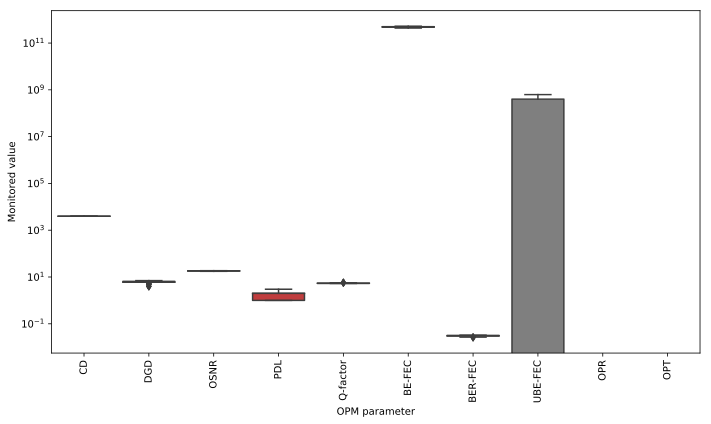

In [8]:
# Identifying `min` and `max` values for each attribute, and building new dataset without these min/max values
to_drop = []
for parameter in final_dataframe.columns:
    if 'min' in parameter or 'max' in parameter:
        to_drop.append(parameter)

final_dataframe_dropped = final_dataframe.drop(to_drop, axis=1)

# Plotting the boxplot (illustrates the distributions present in each one of the features)
plt.figure(figsize=fig_size)
sns.boxplot(data=final_dataframe.drop(to_drop + ['attack'], axis=1))
# .boxplot(figsize=fig_size, rot=90, fontsize=16)
ticks = plt.xticks()
plt.yscale('log')
plt.xticks(ticks[0], ticks[1], rotation=90, fontsize=rcParams['font.size'])
plt.ylabel('Monitored value', fontsize=rcParams['font.size'])
plt.xlabel('OPM parameter', fontsize=rcParams['font.size'])
plt.grid(False)
plt.tight_layout()
plt.savefig('./figures/boxplot-raw.eps')

### Normalizing the values of the dataset and plotting the boxplot for the normalized dataset
As we can see, the normalization process brings the average values of all the features close to zero, enabling better learning for the machine learning algorithms.

/Users/carlosns/tensorenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/carlosns/tensorenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


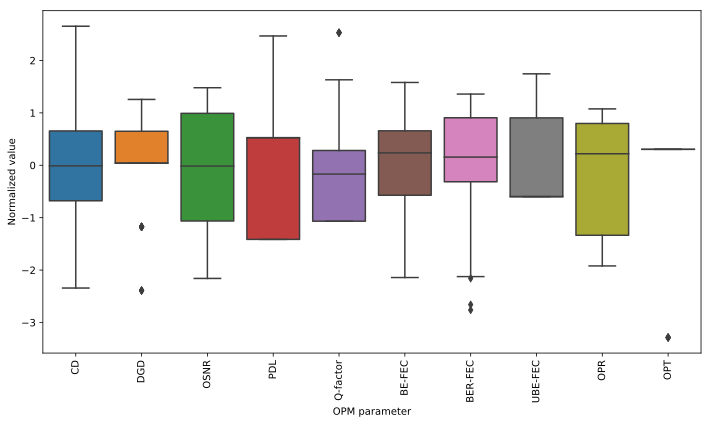

In [9]:
scaler = preprocessing.StandardScaler().fit(final_dataframe.drop(['attack'], axis=1))
x_scaled = scaler.transform(final_dataframe.drop(['attack'], axis=1))
scaled_final_dataframe = pd.DataFrame(x_scaled, index=final_dataframe.index, columns=final_dataframe.columns[:-1])
y = final_dataframe['attack']

scaled_dataframe_dropped = scaled_final_dataframe.drop(to_drop, axis=1)
scaled_dataframe_dropped['attack'] = y

plt.figure(figsize=fig_size)
sns.boxplot(data=scaled_final_dataframe.drop(to_drop, axis=1))
# .boxplot(figsize=fig_size, rot=90, fontsize=16)
ticks = plt.xticks()
plt.xticks(ticks[0], ticks[1], rotation=90)
plt.ylabel('Normalized value')
plt.xlabel('OPM parameter')
plt.grid(False)
plt.tight_layout()
plt.savefig('./figures/boxplot-normalized.eps')

### Generating violin plots, which are more informative than boxplots.

Violin plots represent the average, statistics and distribution of the data, making it more effective than boxplot (above) in representing the properties of a dataset.

#### original dataset

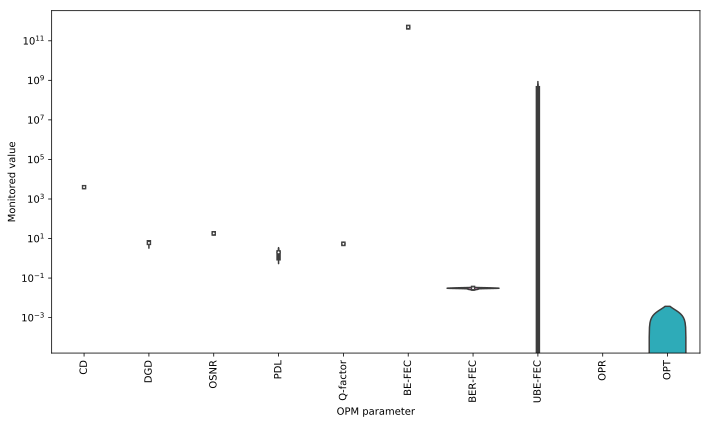

In [10]:
plt.figure(figsize=fig_size)
sns.violinplot(data=final_dataframe.drop(to_drop + ['attack'], axis=1))
ticks = plt.xticks()
plt.yscale('log')
plt.xticks(ticks[0], ticks[1], rotation=90)
plt.xlabel('OPM parameter')
plt.ylabel('Monitored value')
plt.tight_layout()
# plt.savefig('./figures/violin-raw.eps')

#### normalized dataset

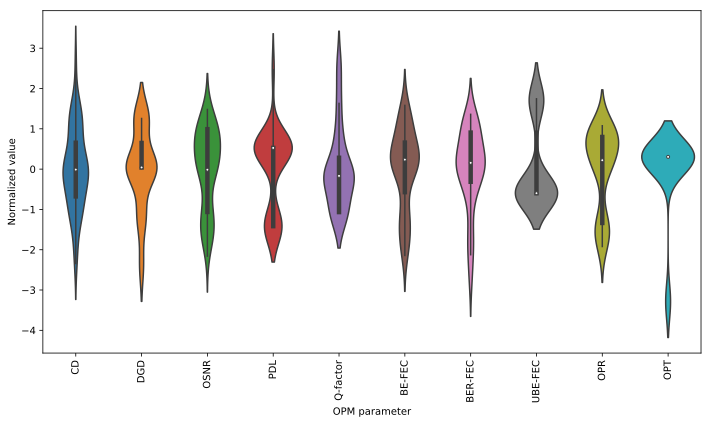

In [11]:
plt.figure(figsize=fig_size)
sns.violinplot(data=scaled_final_dataframe.drop(to_drop, axis=1))
ticks = plt.xticks()
plt.xticks(ticks[0], ticks[1], rotation=90)
plt.xlabel('OPM parameter')
plt.ylabel('Normalized value')
plt.tight_layout()
# plt.savefig('./figures/violin-normalized.eps')

## Principal component analysis (PCA)

### PCA for the normalized dataset
Using the normalized dataset, it is possible to identify more clearly the different dimensions of the data, and a higher distance is observed between the samples.

<Figure size 720x432 with 0 Axes>

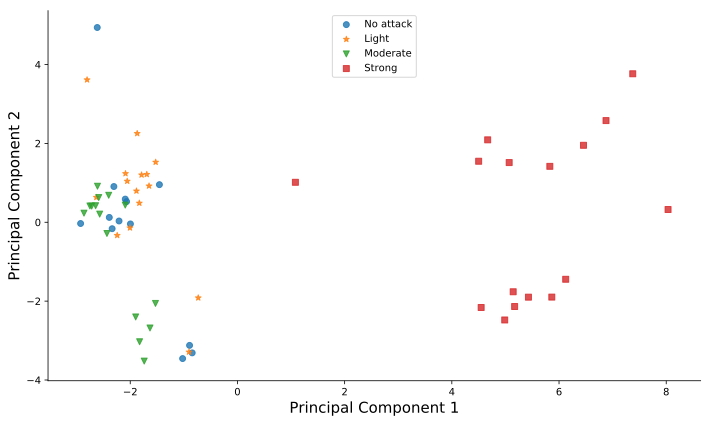

In [12]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_scaled)
principalDf = pandas.DataFrame(data=principalComponents
                                   , columns=['principal component 1', 'principal component 2'])
finalDf = pandas.concat([principalDf, final_dataframe[['attack']]], axis=1)
plt.figure(figsize=fig_size)
# ax = fig.add_subplot(1,1,1)

# plt.title('2 component PCA', fontsize=20)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
markers = ['o', '*', 'v', 's']
sns.lmplot(x='principal component 1', 
               y='principal component 2',
               data=finalDf,
          fit_reg=False,
          hue='attack', markers=markers, legend=False, legend_out=False, height=fig_size[1], aspect=fig_size[0]/fig_size[1]) #, palette='Set3')

plt.legend(class_names, loc=9)
plt.xlabel('Principal Component 1', fontsize=15)
plt.ylabel('Principal Component 2', fontsize=15)

plt.tight_layout()
# plt.savefig('./figures/pca-normalized.eps')

## Correlation analysis
### Correlation analysis considering the entire dataset

One important thing is to mention that the normalization performed in the dataset preserves the correlation between parameters. An illustration is given in the first plot below.

As we can see, there is no clear indication that allows us to identify the attacks. Therefore, we need to analyze how the correlation behaves for the system with a particular attack scenario.

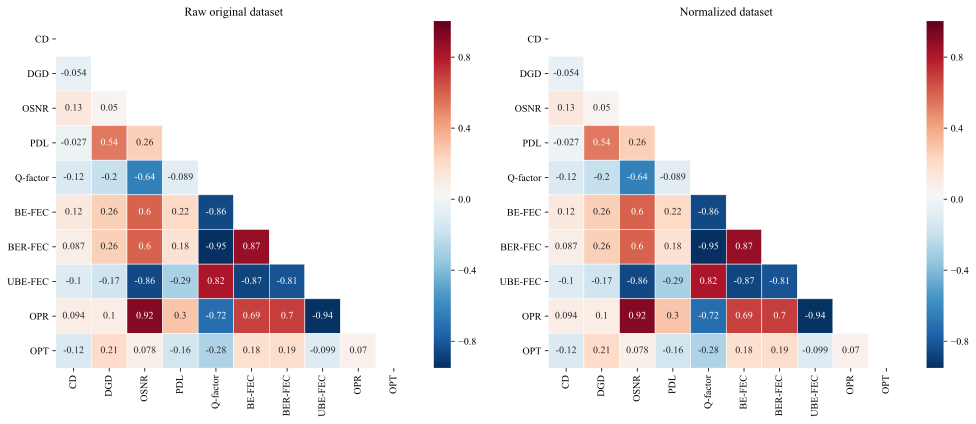

In [32]:
f, ax = plt.subplots(1, 2, figsize=(fig_size[0]+4, fig_size[1]))

corr = final_dataframe_dropped.drop('attack', axis=1).corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, linewidths=.5, mask=mask, linecolor='white', cmap="RdBu_r", ax=ax[1], annot=True)
ax[0].set_title('Raw original dataset')

corr = scaled_dataframe_dropped.drop('attack', axis=1).corr()

sns.heatmap(corr, linewidths=.5, mask=mask, linecolor='white', cmap="RdBu_r", ax=ax[0], annot=True)
ax[1].set_title('Normalized dataset')

plt.tight_layout()
# plt.savefig('./figures/correlation-full-dataset.eps')
# plt.show()
# plt.close()

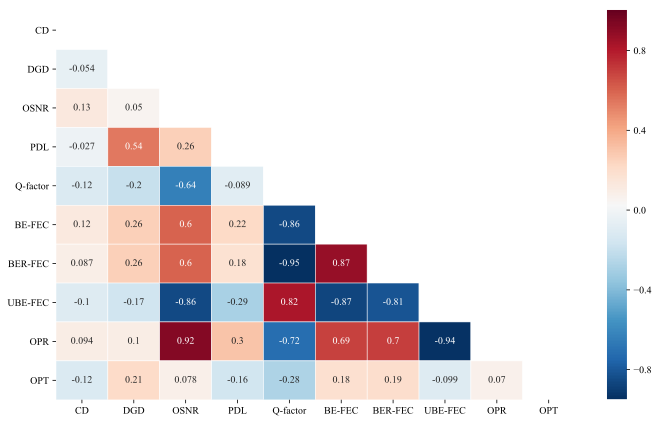

In [33]:
corr = scaled_dataframe_dropped.drop('attack', axis=1).corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=fig_size)
sns.heatmap(corr, linewidths=.5, mask=mask, linecolor='white', cmap="RdBu_r", annot=True)

plt.tight_layout()
# plt.savefig('./figures/correlation-full-dataset.eps')

### Correlation analysis for each attack scenario


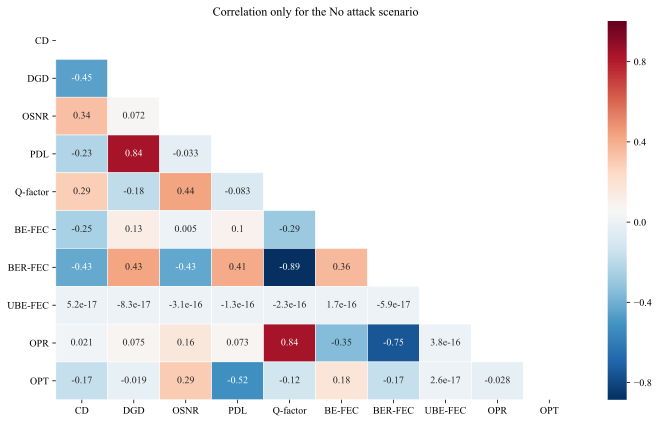

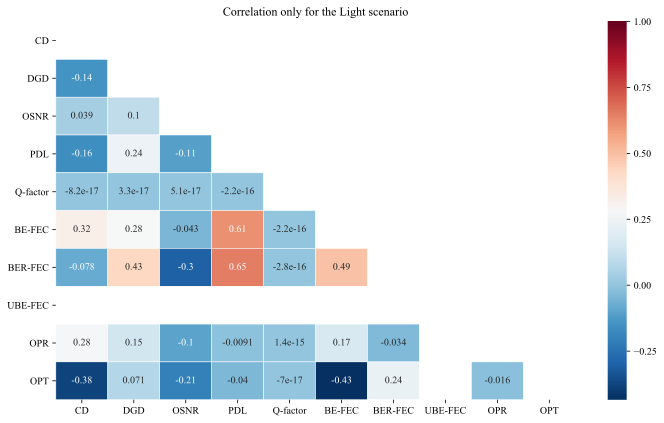

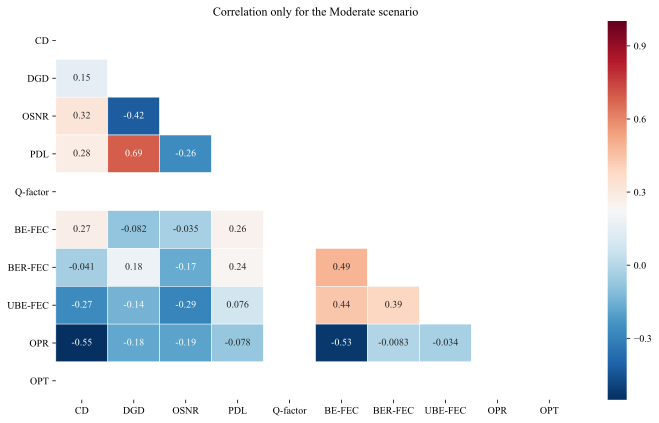

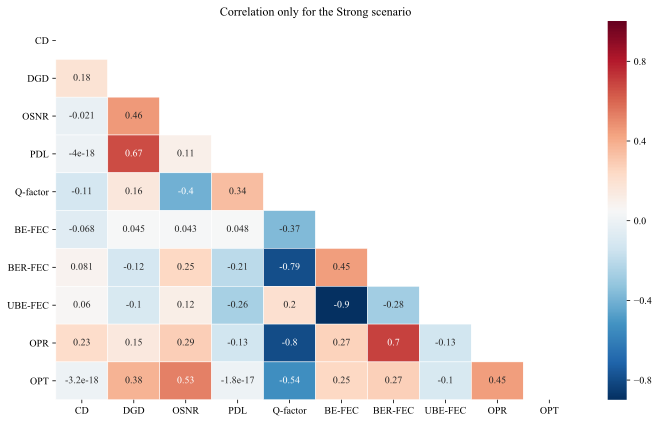

In [34]:
for attack in range(0, 4):
    corr = scaled_dataframe_dropped.where(scaled_dataframe_dropped['attack'] == attack).drop('attack', axis=1).corr()

    plt.figure(figsize=fig_size)
    sns.heatmap(corr, linewidths=.5, mask=mask, linecolor='white', cmap="RdBu_r", annot=True)
    plt.title('Correlation only for the ' + class_names[attack] + ' scenario')

    plt.tight_layout()
#     plt.savefig('./figures/correlation-attack-' + str(attack) + '.eps')
#     plt.show()

### Computing the correlation difference from the no attack scenario
#### We are plotting the values for our own reference. For the paper, the explicit values for each cell can be removed.
#### Note that for the moderate attack, Q-factor, UBE-FEC and OPT have NaN correlation (division by zero). I would suggest showing only light and strong attack in the paper.
Here, we can show how the correlation changes from the normal operation conditions.
Before moving to the indications of attacks, the moderate attack scenario seems to have a strange behavior regarding the correlation.
The main indicatives are:
- Correlation OPR<>BER-FEC changes when attacks are being launched, considering a general trend, i.e., it moves from a negative correlation in the normal conditions (-0.75, as seen above) to 0.7 (see above), which means it goes from strong negative correlation to strong positive correlation. In other words, in attack conditions, BER-FEC grows with received power.
- Correlation OPR<>Q-Factor also presents a considerable change. It goes from strong positive correlation (0.84) in normal operation conditions, to a relatively strong negative correlation (-0.54) when under strong attacks. This brings similar conclusions as the OPR<>BER-FEC case.

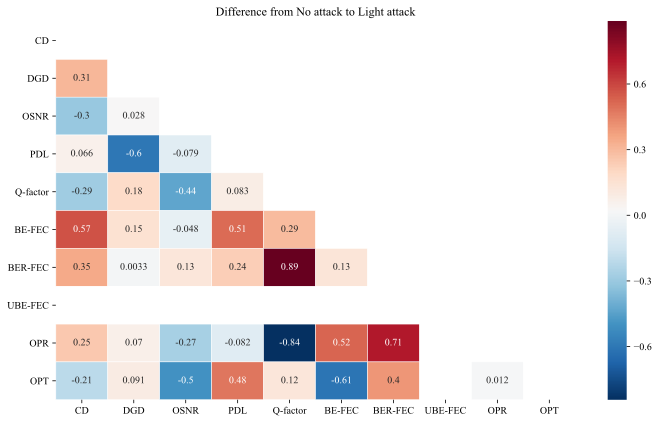

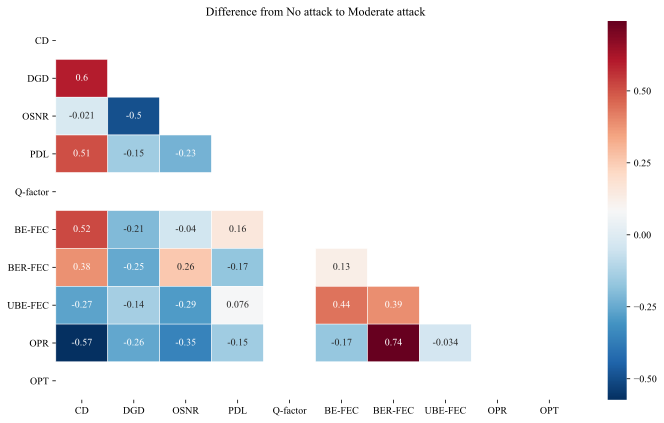

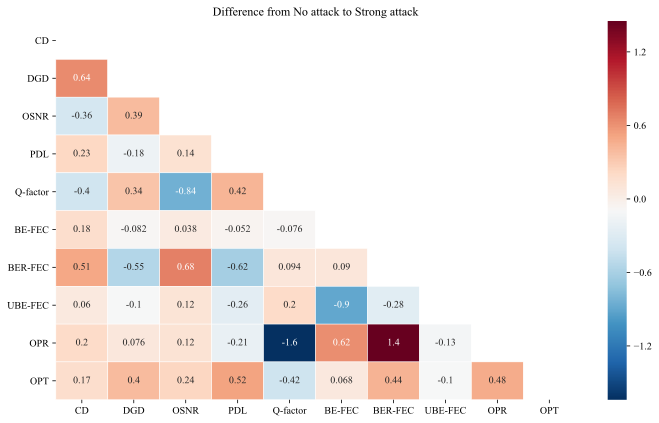

In [36]:
no_attack_corr = scaled_dataframe_dropped.where(scaled_dataframe_dropped['attack'] == 0).drop('attack', axis=1).corr()

for attack in range(1, 4):
    corr = scaled_dataframe_dropped.where(scaled_dataframe_dropped['attack'] == attack).drop('attack', axis=1).corr()

    plt.figure(figsize=fig_size)
    sns.heatmap(corr - no_attack_corr, linewidths=.5, mask=mask, linecolor='white', annot=True, cmap="RdBu_r")
    plt.title('Difference from ' + class_names[0] + ' to ' + class_names[attack] + ' attack')

    plt.tight_layout()
#     plt.savefig('./figures/correlation-difference-from-no-attack-' + str(attack) + '.eps')
#     plt.show()

### Timeline with the correlation
Here, our goal is to demonstrate how one can identify attacks by monitoring the correlation between these three key parameters identified in the last step (i.e., OPR, Q-factor and BER-FEC).

In this case, we have a definition of a `step`, which is the number of samples that are used to compute the correlation. Having the last 10 samples did not yeld good results. I suggest using the figures that analyze the last 20 and 30 samples.

We can see that the correlation trend changes over time as the attack happens. This demonstrates how the intuition provided with the correlation matrices can be used for attack detection.

One drawback of this approach is that the correlation takes time to converge, and therefore the attack can remain undetected for several monitoring cycles.

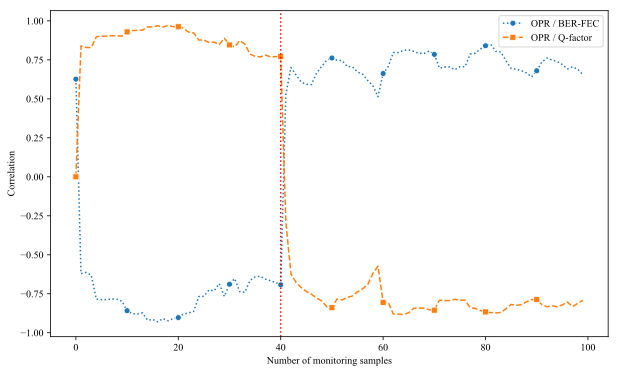

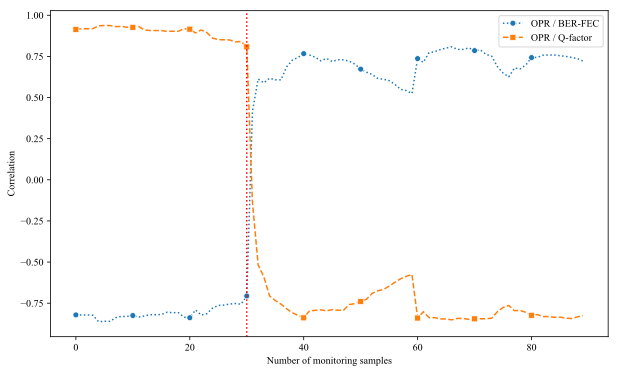

In [37]:
steps = [20, 30]
samples_per_attack = 60

X = []

for att in [0, 3]:
    for s in range(samples_per_attack):
        i = (att * samples_per_attack) + s
        samples = scaled_dataframe_dropped[(scaled_dataframe_dropped['attack'] == att)].sample(n=1)
#         for sample in samples.values:
#             X.append(sample)
#         print(att, s, sample.values[0])
        X.append(samples.values[0])
#         Y[i] = sample.values[-1]

X = np.reshape(X, newshape=(len(X), len(X[0])))
correlation_dataframe = pd.DataFrame(data=X, columns=scaled_dataframe_dropped.columns)

correlations = {}
attack_change = {}

for step in steps:
    correlations[step] = {}
    correlations[step]['OPR<>BER-FEC'] = []
    correlations[step]['OPR<>Q-factor'] = []
    attack_change[step] = []
    last_attack = 0
    for start in range(0, len(correlation_dataframe) - step):
        attack_change[step].append(correlation_dataframe.iloc[start+step]['attack'] != last_attack)
        last_attack = correlation_dataframe.iloc[start+step]['attack']
            
        corr = correlation_dataframe.drop('attack', axis=1).iloc[start:start+step].corr()
        correlations[step]['OPR<>BER-FEC'].append(corr['OPR']['BER-FEC'])
        correlations[step]['OPR<>Q-factor'].append(corr['OPR']['Q-factor'])
#         print(step, start, start+step, attack_change[step][-1], corr['OPR']['BER-FEC'], corr['OPR']['Q-factor'])
#     print('')

for step in steps:
    plt.figure(figsize=fig_size)
    ax1 = sns.lineplot(range(0, len(correlations[step]['OPR<>BER-FEC'])), correlations[step]['OPR<>BER-FEC'], label='OPR / BER-FEC')
    ax2 = sns.lineplot(range(0, len(correlations[step]['OPR<>Q-factor'])), correlations[step]['OPR<>Q-factor'], label='OPR / Q-factor')
    ax2.lines[0].set_linestyle(":")
    ax2.lines[0].set_marker("o")
    ax2.lines[0].set_markevery(10)
    ax2.lines[1].set_linestyle("--")
    ax2.lines[1].set_marker("s")
    ax2.lines[1].set_markevery(10)
#     plt.plot(range(0, len(correlations[step]['OPR<>BER-FEC'])), correlations[step]['OPR<>BER-FEC'], label='OPR<>BER-FEC')
#     plt.plot(range(0, len(correlations[step]['OPR<>Q-factor'])), correlations[step]['OPR<>Q-factor'], label='OPR<>Q-factor')
    for x, att in enumerate(attack_change[step]):
        if att:
            plt.axvline(x, color='red', linestyle=':')
    plt.xlabel('Number of monitoring samples')
    plt.ylabel('Correlation')
    plt.legend()
#     plt.savefig('./figures/timeline-correlation-' + str(step) + '_steps.eps')
#     plt.show()

## Implementation of the density-based clustering (DBSCAN - [Original paper](http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf))

Here, the main question we want to ask is the following: how do you configure your unsupervised learning algorithm if you haven't seen any attack so far?

In Chen et. al (2019) ([IEEEXplore](https://ieeexplore.ieee.org/abstract/document/8535185/), [ResearchGate](https://www.researchgate.net/publication/326007616_On_Real-Time_and_Self-Taught_Anomaly_Detection_in_Optical_Networks_Using_Hybrid_UnsupervisedSupervised_Learning)), it is shown only the configuration when the anomalies are already known a priori. Here we are taking another approach, that is to find in which way we can have a "tight" configuration such that an anomaly can be identified.

### identifying configuration which identifies all the normal samples as "normal"

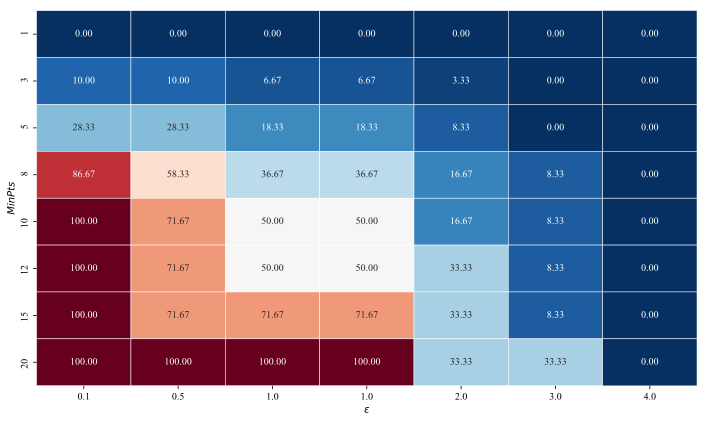

In [38]:
X = scaled_dataframe_dropped[(scaled_dataframe_dropped['attack'] == 0)].drop('attack', axis=1).values
# X = scaled_final_dataframe.where(scaled_final_dataframe['attack'] == 0).drop(to_drop, axis=1).values
X = correlation_dataframe[(correlation_dataframe['attack'] == 0)].drop('attack', axis=1).values

# final_dataframe_dropped
# X = final_dataframe_dropped[(final_dataframe_dropped['attack'] == 0)].drop('attack', axis=1).values

labels_true = scaled_dataframe_dropped[(scaled_dataframe_dropped['attack'] == 0)]['attack'].values
labels_true = correlation_dataframe[(correlation_dataframe['attack'] == 0)]['attack'].values

epsilon_configurations = [.1, .5, 1., 1., 2., 3., 4.]
min_samples_configurations = [1, 3, 5, 8, 10, 12, 15, 20]

values = np.zeros((len(min_samples_configurations), len(epsilon_configurations)))

predictors = np.empty((len(min_samples_configurations), len(epsilon_configurations)), dtype=DBSCAN)

for idm, min_samples in enumerate(min_samples_configurations):

    for ide, epsilon in enumerate(epsilon_configurations):

        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
        db = dbscan.fit(X)
        labels = db.labels_
#         print(min_samples, epsilon, labels)
        values[idm, ide] = (np.sum([1 for label in labels if label == -1]) * 100) / len(X)
        predictors[idm, ide] = dbscan

plt.figure(figsize=fig_size)
sns.heatmap(values, linewidths=.5, linecolor='white', annot=True, cmap="RdBu_r", cbar=False, fmt='.2f')

plt.ylabel('$MinPts$')
plt.yticks([x + .5 for x in range(0, len(min_samples_configurations))], min_samples_configurations)

plt.xlabel('$\epsilon$')
plt.xticks([x + .5 for x in range(0, len(epsilon_configurations))], epsilon_configurations)

plt.tight_layout()
# plt.savefig('./figures/number-false-positives-no-attack.eps')
# plt.show()

### Checking now which configuration yelds the best results

These results are presented in Table 2 of the paper.

In [40]:
for attack in range(1, 4):
    print('\nresults for attack', attack)
    
    X1 = final_dataframe_dropped[(final_dataframe_dropped['attack'] == 0)].drop('attack', axis=1).values
    X2 = final_dataframe_dropped[(final_dataframe_dropped['attack'] == attack)].drop('attack', axis=1).values[:10]
    X = np.concatenate((X1, X2), axis=0)
    
    Y1 = final_dataframe_dropped[(final_dataframe_dropped['attack'] == 0)]['attack'].values
    Y2 = final_dataframe_dropped[(final_dataframe_dropped['attack'] == attack)]['attack'].values[:10]
    labels_true = np.concatenate((Y1, Y2), axis=0)

    for epsilon in epsilon_configurations:
        print('\t', epsilon, end='\t')
    print('')

    for ide, epsilon in enumerate(epsilon_configurations):
        print('\t(fp, fn) %', end='')
    print('')
    
    for idm, min_samples in enumerate(min_samples_configurations):
        print(min_samples, end='\t')

        for ide, epsilon in enumerate(epsilon_configurations):

#             dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
#             db = dbscan.fit(X)
#             print('idm', idm, ide, np.shape(predictors))
            labels = predictors[idm, ide].fit_predict(X)
#             print(len(db))
            
#             labels = db.labels_
            false_positives = np.sum([1 if label == -1 else 0 for true_label, label in zip(labels_true, labels) if true_label == 0])
            false_negatives = np.sum([1 if label > -1 else 0 for true_label, label in zip(labels_true, labels) if true_label > 0])

            print('%0.2f,' % (false_positives * 100 / len(X)), '%0.2f' % (false_negatives * 100 / len(X)), end='\t')
        print('')


results for attack 1
	 0.1		 0.5		 1.0		 1.0		 2.0		 3.0		 4.0	
	(fp, fn) %	(fp, fn) %	(fp, fn) %	(fp, fn) %	(fp, fn) %	(fp, fn) %	(fp, fn) %
1	0.00, 43.48	0.00, 43.48	0.00, 43.48	0.00, 43.48	0.00, 43.48	0.00, 43.48	0.00, 43.48	
3	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	
5	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	
8	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	
10	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	
12	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	
15	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	
20	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	56.52, 0.00	

results for attack 2
	 0.1		 0.5		 1.0		 1.0		 2.0		 3.0		 4.0	
	(fp, fn) %	(fp, fn) %	(fp, fn) %	(fp, fn) %	(fp, fn) %	(fp, fn) %	(fp, fn) %
1	0.00, 43.48	